# Machine Learning In Action

(Heavily inspired by Chapter 2 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

## Summary

- Environment setup
- Step 1: frame the problem
- Step 2: collect, analyze and prepare data
- Step 3: select and train models
- Step 4: tune the selected model
- Step 5: deploy to production and maintain the system

## Environment setup

Our core toolset is:

- [Python](../tools/python.ipynb), a multi-purpose programming language well suited to Data Science and ML.
- [NumPy](../tools/numpy.ipynb), a Python library providing support for large, multi-dimensional arrays.
- [Matplotlib](../tools/matplotlib.ipynb), a comprehensive library for creating visualizations in Python.
- [pandas](../tools/pandas.ipynb), a Python library providing easy-to-use data structures and data analysis tools.
- [scikit-learn](../tools/scikit-learn.ipynb), a versatile Python library for Machine Learning.

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import joblib  # For saving models to disk

scikit-learn version: 0.22.1


## Step 1: frame the problem

- What is the business objective?
- How good are the current solutions?
- What data is available?
- Is the problem a good fit for ML?
- What is the expected learning type (supervised or not, batch/online...)?
- How will the model's performance be evaluated?

### Properties of ML-friendly problems

- Difficulty to express the actions as rules.
- Data too complex for traditional analytical methods:
  - High number of features.
  - Highly correlated data (data with similar or closely related values).
- Performance > explicability.

### Example: predict house prices

- Inputs: housing properties in an area
- Output: median housing price in the area

[![Kaggle houses banner](images/kaggle_housesbanner.png)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

## Step 2: collect, analyze and prepare data

Data quality is **paramount** for any ML project.

![Your data, your model](images/yourdata_yourmodel.png)

### Predefined datasets Vs real data

Real data is messy, incomplete and often scattered across many sources.

Data labeling is a manual and tedious process.

Predefined datasets offer a convenient way to bypass the data wrangling step. Alas, using one is not always an option.

### Example: the California housing dataset

- Based on data from the 1990 California census.
- Slightly modified for teaching purposes by A. Géron ([original version](https://www.dcc.fc.up.pt/%7Eltorgo/Regression/cal_housing.html)).

### Step 2.1: discover data

Our first objective is to familiarize ourselves with the dataset.

Once data is loaded, the **pandas** library  provides many useful functions for making sense of it.

In [4]:
# Load the dataset in a pandas DataFrame
dataset_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
df_housing = pd.read_csv(dataset_url)

# Print dataset shape (rows and columns)
print(f"Dataset shape: {df_housing.shape}")

Dataset shape: (20640, 10)


In [5]:
# Print a concise summary of the dataset
# 9 attributes are numerical, one ("ocean_proximity") is categorical
# "median_house_value" is the target attribute
# One attribute ("total_bedrooms") has missing values
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Show the 10 first samples
df_housing.head(n=10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [7]:
# Print descriptive statistics for all numerical attributes
df_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


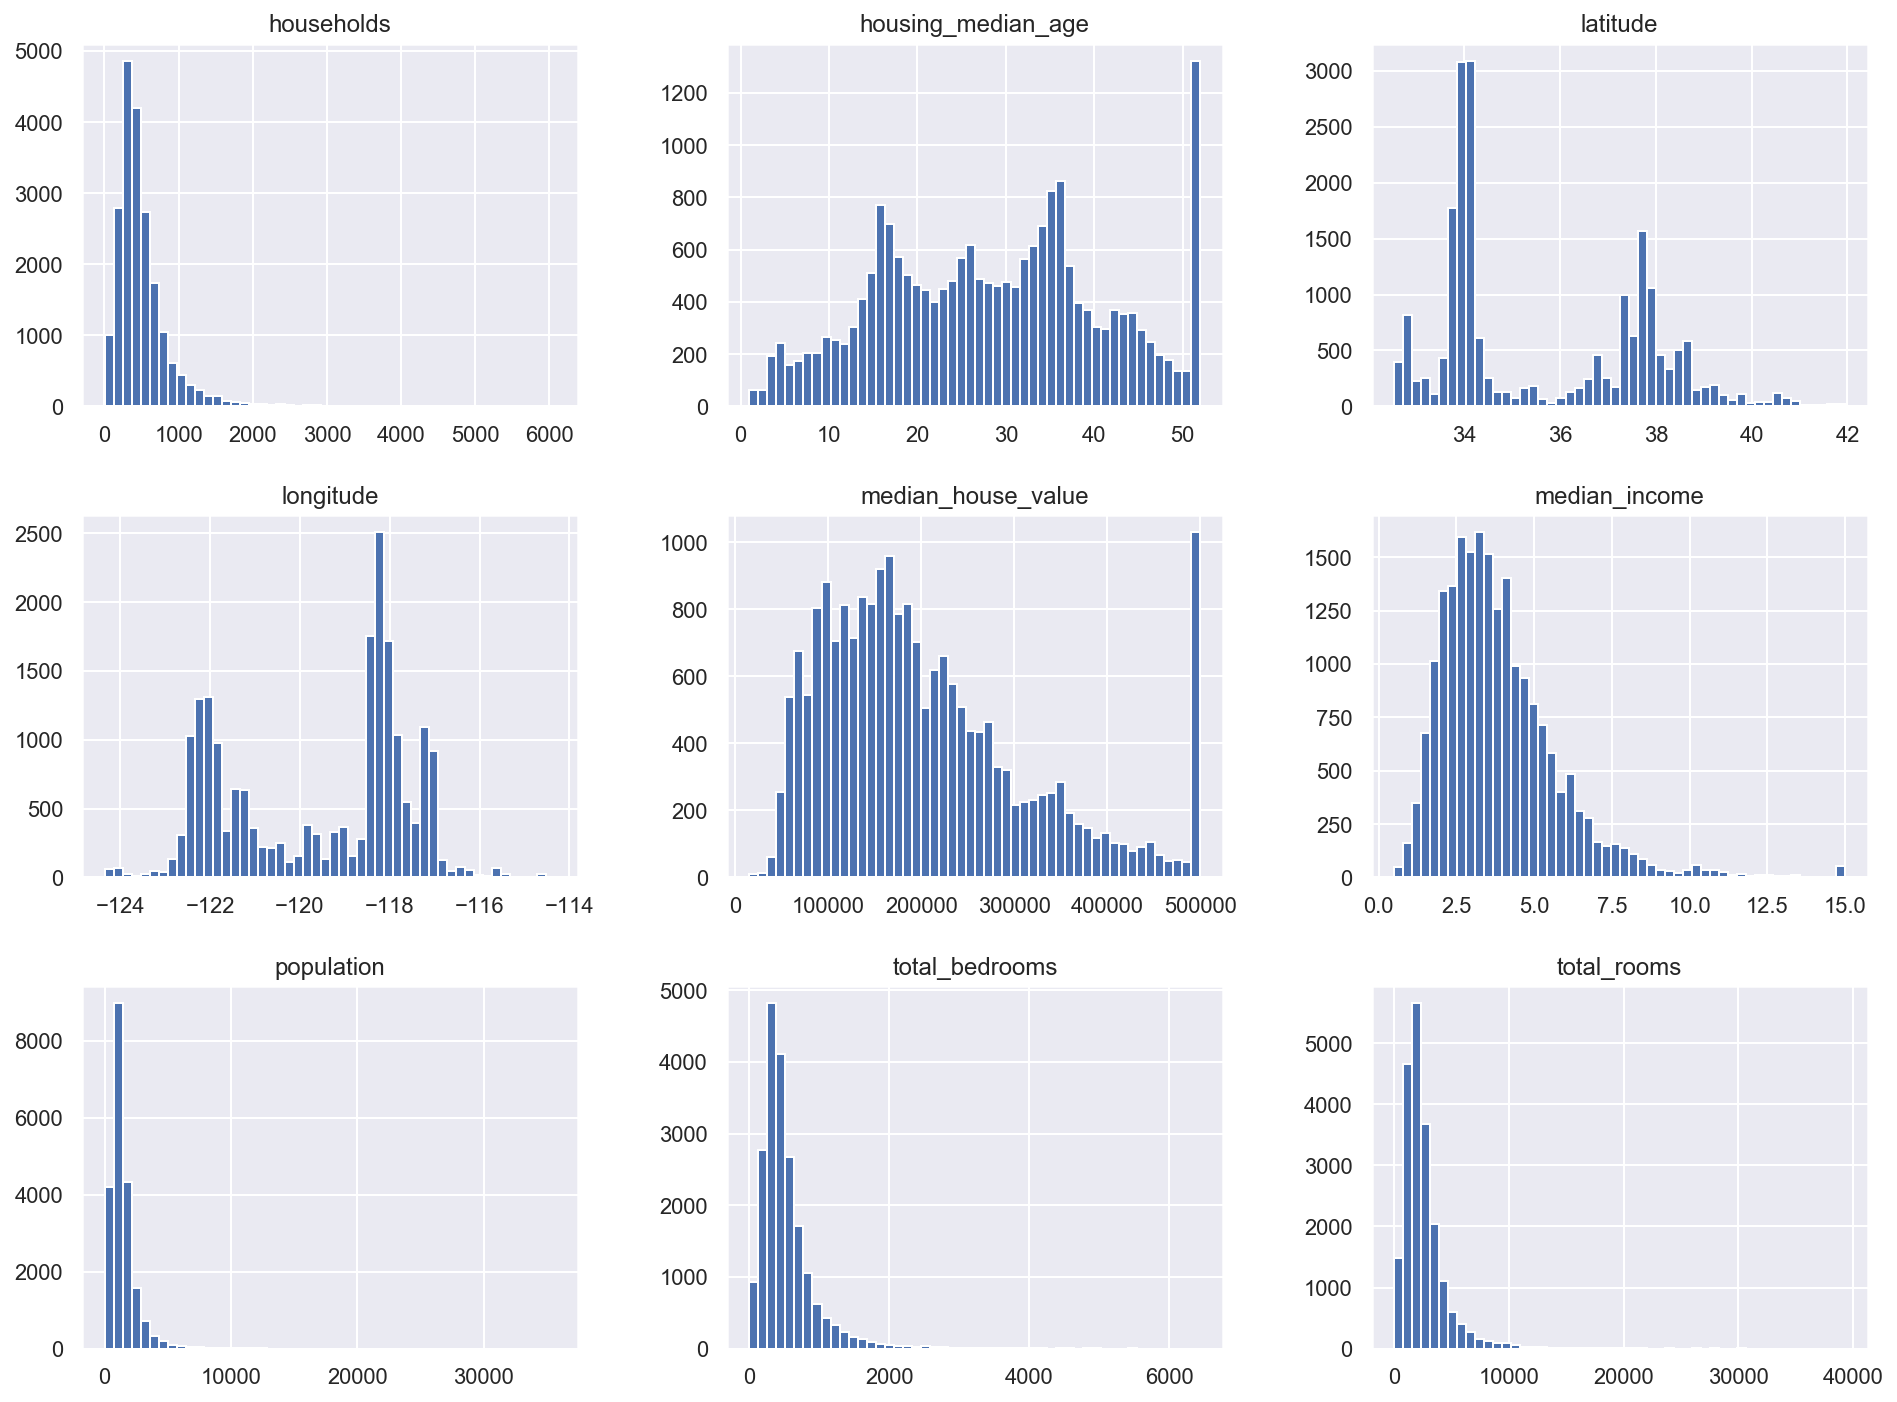

In [8]:
# Plot histograms for all numerical attributes
df_housing.hist(bins=50, figsize=(16, 12))
plt.show()

### Step 2.2: create a test set

Once deployed, a model must be able to **generalize** (perform well with new, never-seen-before data).

In order to assert this ability, data is typically split into 2 or 3 sets:

- **Training set** (typically 80% or more): fed to the model during training.
- **Validation set**: used to tune the model.
- **Test set**: used to check the model's performance on unknown data.

In [9]:
# Split dataset between training and test
df_train, df_test = train_test_split(df_housing, test_size=0.2)

print(f"Training dataset: {df_train.shape}")
print(f"Test dataset: {df_test.shape}")

Training dataset: (16512, 10)
Test dataset: (4128, 10)


### Step 2.3: analyze data

The objective here is to gain insights about the data, in order to prepare it optimally for training.

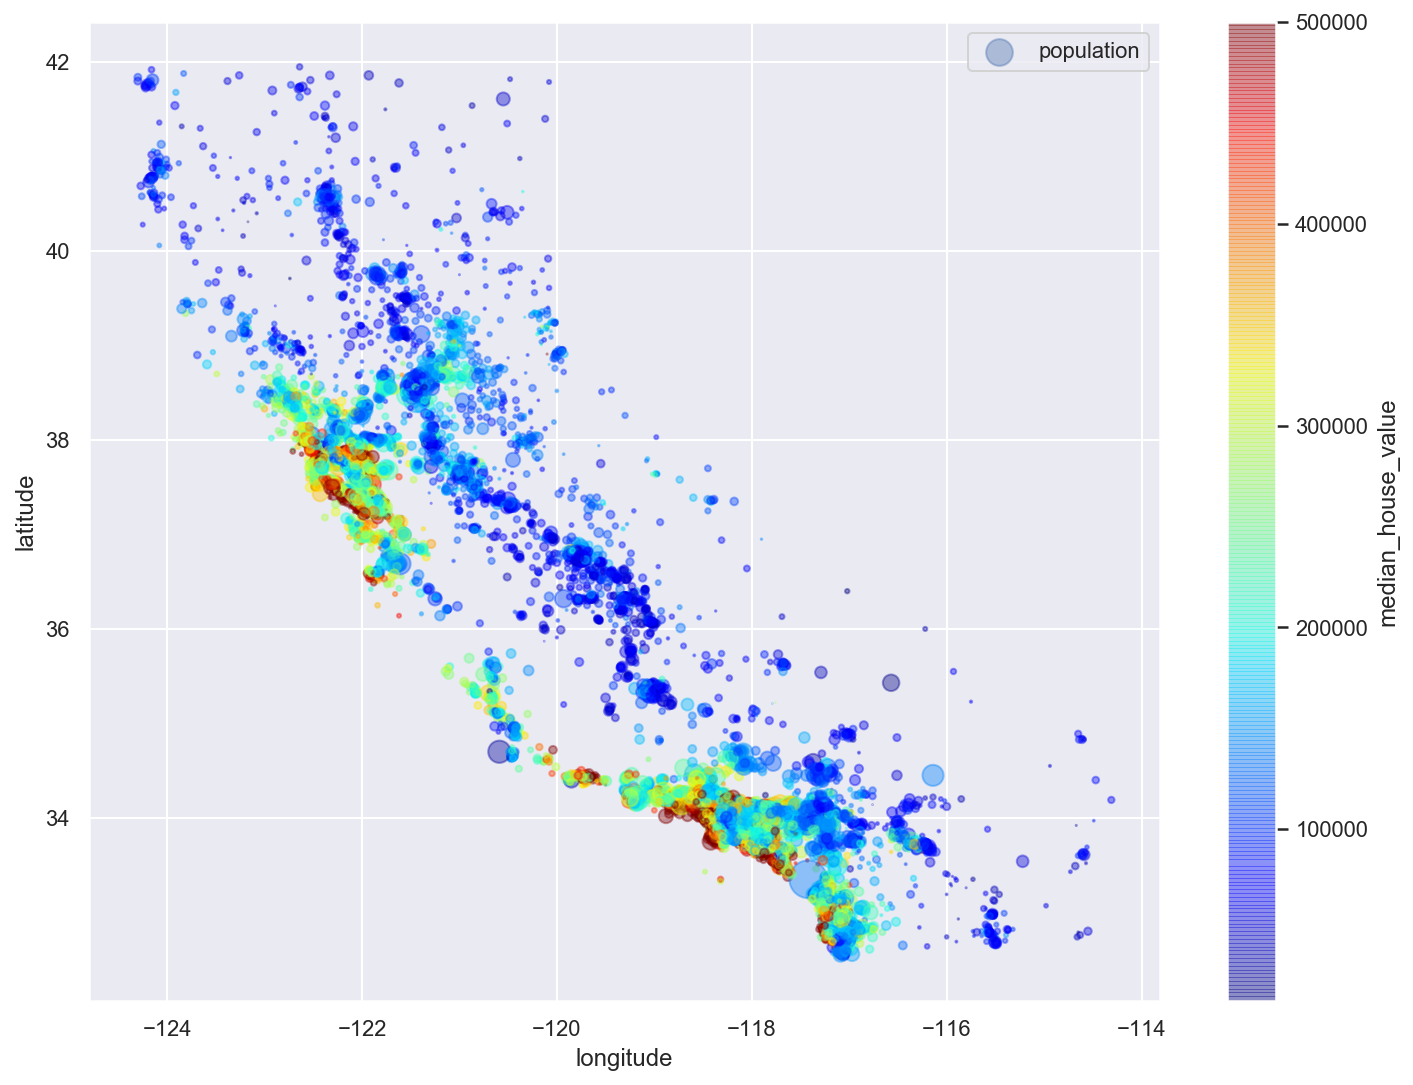

In [10]:
# Visualise prices relative to geographical coordinates
df_train.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=df_train["population"] / 100,
    label="population",
    figsize=(12, 9),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False,
)
plt.legend()
plt.show()

In [11]:
# Compute pairwise correlations of attributes
corr_matrix = df_train.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689557
total_rooms           0.139464
housing_median_age    0.106695
households            0.067366
total_bedrooms        0.050744
population           -0.025604
longitude            -0.048522
latitude             -0.144150
Name: median_house_value, dtype: float64

In [12]:
# Plot correlation matrix
def plot_correlation_matrix(df):
    # Select numerical columns
    df_numerical = df.select_dtypes(include=[np.number])

    f, ax = plt.subplots()
    ax = sns.heatmap(
        df.corr(),
        vmax=0.8,
        linewidths=0.01,
        square=True,
        annot=True,
        linecolor="white",
        xticklabels=df_numerical.columns,
        annot_kws={"size": 13},
        yticklabels=df_numerical.columns,
    )
    # Correct a regression in matplotlib 3.1.1 https://stackoverflow.com/a/58165593
    # bottom, top = ax.get_ylim()
    # ax.set_ylim(bottom + 0.5, top - 0.5)

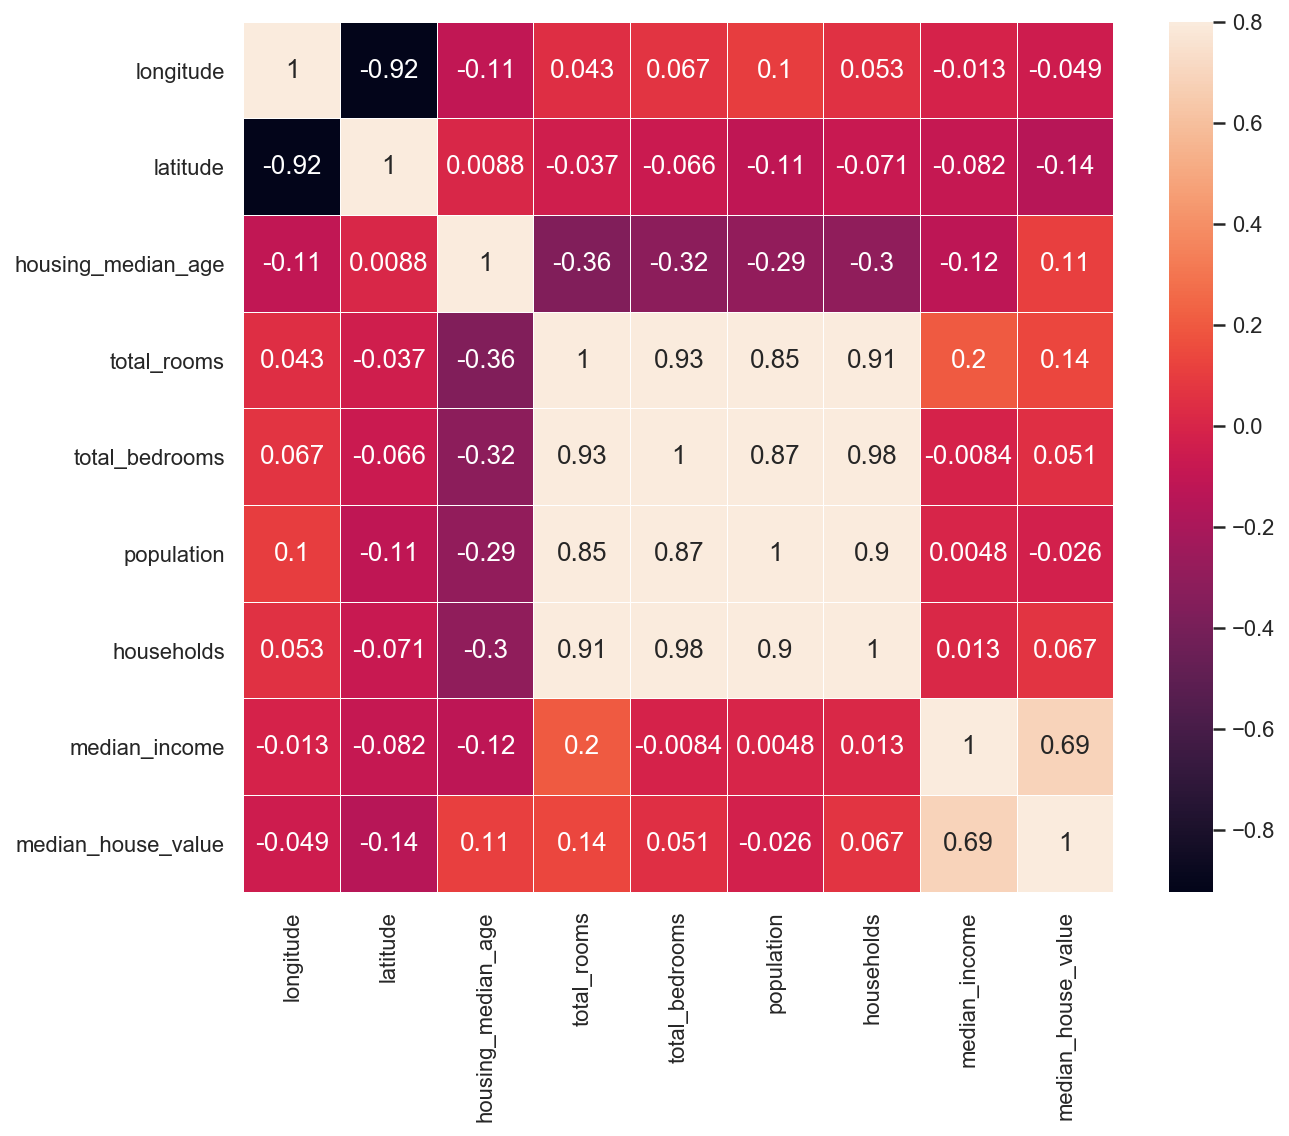

In [13]:
plot_correlation_matrix(df_train)

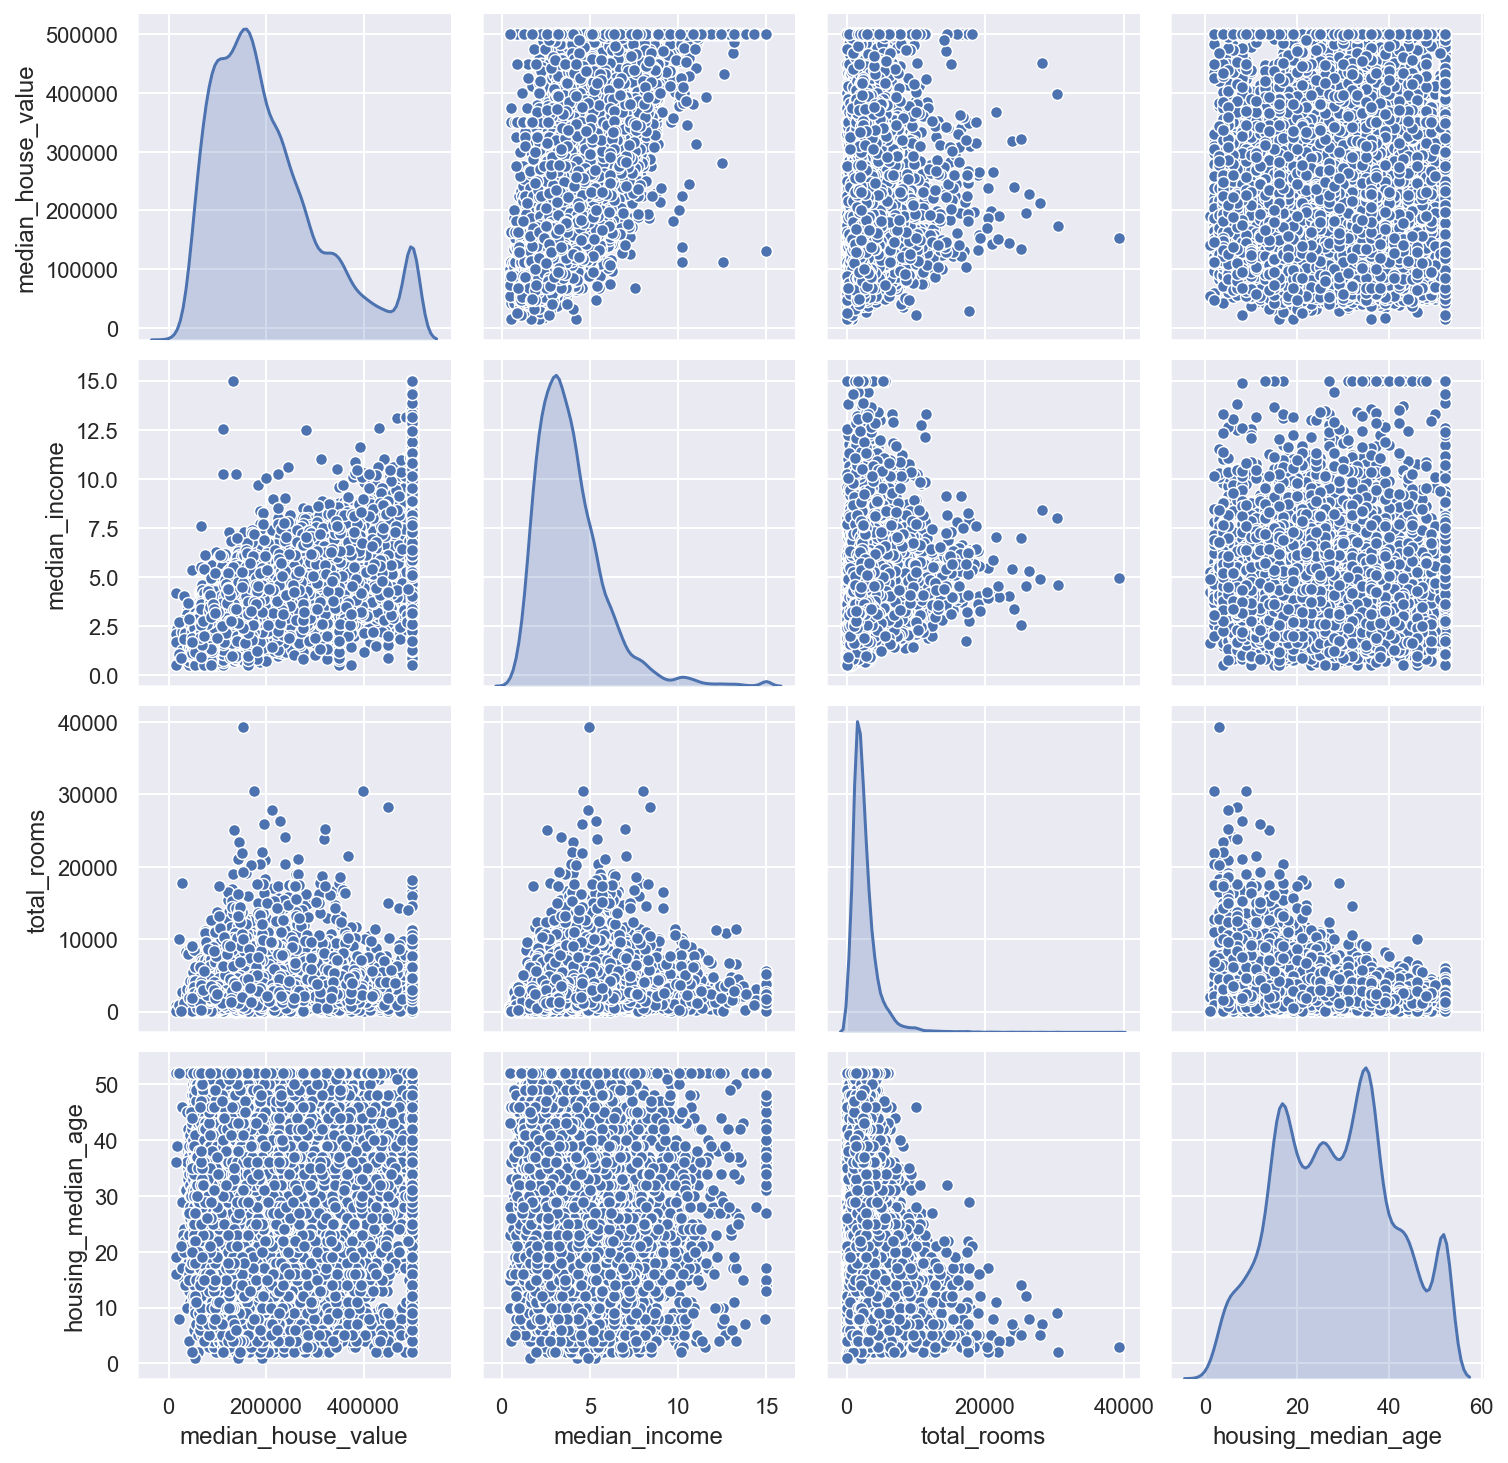

In [14]:
# Plot relationships between median house value and most promising attributes
corr_attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age",
]
sns.pairplot(df_train[corr_attributes], diag_kind="kde")
plt.show()

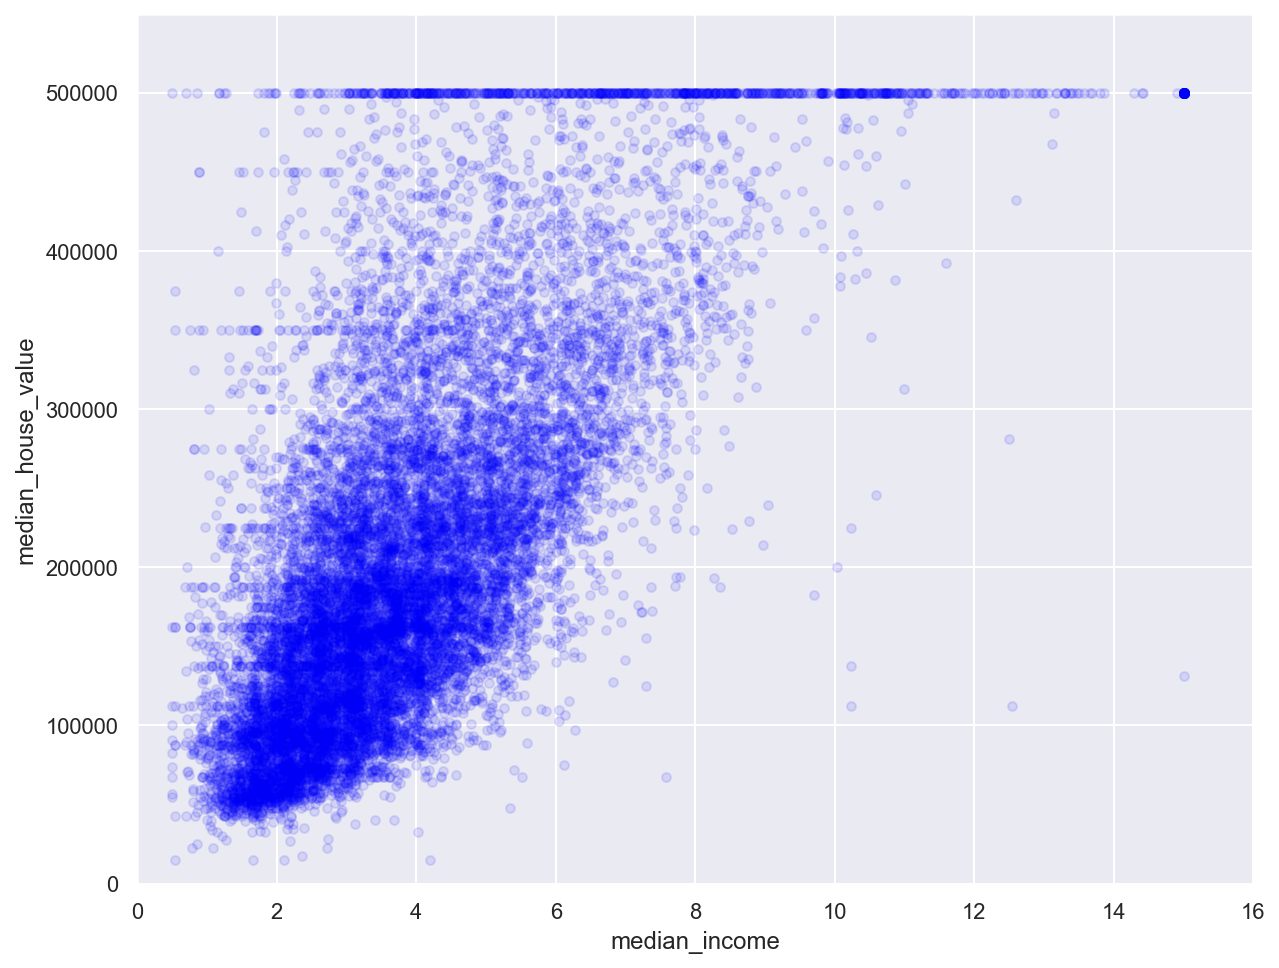

In [15]:
# Plot relationship between median house value and median income
df_train.plot(
    kind="scatter", x="median_income", y="median_house_value", alpha=0.1, c="blue"
)
plt.axis([0, 16, 0, 550000])
plt.show()

### Step 2.4: feature engineering

An optional but often useful step is to create new data attributes (called **features**) by combining or transforming existing ones.

In [16]:
# Make a deep copy of the dataset
df_housing_eng = df_train.copy()

# Add new features to the dataset
df_housing_eng["rooms_per_household"] = (
    df_housing_eng["total_rooms"] / df_housing_eng["households"]
)
df_housing_eng["bedrooms_per_room"] = (
    df_housing_eng["total_bedrooms"] / df_housing_eng["total_rooms"]
)
df_housing_eng["population_per_household"] = (
    df_housing_eng["population"] / df_housing_eng["households"]
)

# Re-compute correlations
corr_matrix = df_housing_eng.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.689557
rooms_per_household         0.145502
total_rooms                 0.139464
housing_median_age          0.106695
households                  0.067366
total_bedrooms              0.050744
population_per_household   -0.022050
population                 -0.025604
longitude                  -0.048522
latitude                   -0.144150
bedrooms_per_room          -0.255941
Name: median_house_value, dtype: float64

### Step 2.5: data preprocessing

This task typically involves:

- Removing of superflous features (if any).
- Adding missing values.
- Transforming values into numeric form.
- Scaling data.
- Labelling (if needed).

In [17]:
# Split original training dataset between inputs and target
# (engineered features are not used)

# Target attribute is removed from training data
df_x_train = df_train.drop("median_house_value", axis=1)

# Targets are transformed into a NumPy array for further use during training
y_train = df_train["median_house_value"].to_numpy()

print(f"Training data: {df_x_train.shape}")
print(f"Training labels: {y_train.shape}")

Training data: (16512, 9)
Training labels: (16512,)


### Handling missing values

Most ML algorithms cannot work with missing values in features.

Three options exist:
- Remove the corresponding data samples.
- Remove the whole features.
- Replace the missing values (using 0, the mean, the median or something else).

In [18]:
# Compute number and percent of missing values among features
total = df_x_train.isnull().sum().sort_values(ascending=False)
percent = (df_x_train.isnull().sum() * 100 / df_x_train.isnull().count()).sort_values(
    ascending=False
)
df_missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
df_missing_data.head()

,Total,Percent
total_bedrooms,166,1.005329
ocean_proximity,0,0.000000
median_income,0,0.000000
households,0,0.000000
population,0,0.000000


In [19]:
# Show the first samples with missing values
df_x_train[df_x_train.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,INLAND
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,NEAR BAY
6052,-117.76,34.04,34.0,1914.0,NaN,1564.0,328.0,2.8347,INLAND
2412,-119.45,36.61,24.0,1302.0,NaN,693.0,243.0,3.7917,INLAND


In [20]:
# Replace missing values with column-wise mean
inputer = SimpleImputer(strategy="mean")
inputer.fit_transform([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

array([[ 7. ,  2. ,  3. ],
       [ 4. ,  3.5,  6. ],
       [10. ,  5. ,  9. ]])

### Feature scaling

Most ML models work best when all features have a similar scale.

One way to achieve this result is to apply **standardization**, the process of centering and reducing features: they are substracted by their mean and divided by their standard deviation. 

The resulting features have a mean of 0 and a standard deviation of 1. 

In [21]:
# Generate a random (3,3) tensor with values between 1 and 10
x = np.random.randint(1, 10, (3, 3))
print(x)

[[8 7 5]
 [8 9 3]
 [7 1 6]]


In [22]:
# Center and reduce data
scaler = StandardScaler().fit(x)
print(scaler.mean_)

x_scaled = scaler.transform(x)
print(x_scaled)

# New mean is 0. New standard deviation is 1
print(f"Mean: {x_scaled.mean()}. Std: {x_scaled.std()}")

[7.66666667 5.66666667 4.66666667]
[[ 0.70710678  0.39223227  0.26726124]
 [ 0.70710678  0.98058068 -1.33630621]
 [-1.41421356 -1.37281295  1.06904497]]
Mean: -3.20731096002823e-16. Std: 1.0


### One-hot encoding

ML models expect data to be exclusively under numerical form.

**One-hot encoding** produces a matrix of binary vectors from a vector of categorical values.

it is useful to convert categorical features into numerical features without using arbitrary integer values, which could create a proximity relationship between the new values.

In [23]:
# Create a categorical variable with 3 different values
x = [["GOOD"], ["AVERAGE"], ["GOOD"], ["POOR"], ["POOR"]]

# Encoder input must be a matrix
# Output will be a sparse matrix where each column corresponds to one possible value of one feature
encoder = OneHotEncoder().fit(x)
x_hot = encoder.transform(x).toarray()

print(x_hot)
print(encoder.categories_)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
[array(['AVERAGE', 'GOOD', 'POOR'], dtype=object)]


### Preprocessing pipelines

Data preprocessing is done through a series of sequential operations on data (handling missing values, standardization, one-hot encoding...).

scikit-learn support the definition of **pipelines** for streamlining these operations.

In [24]:
# Print numerical features
num_features = df_x_train.select_dtypes(include=[np.number]).columns
print(num_features)

# Print categorical features
cat_features = df_x_train.select_dtypes(include=[np.object]).columns
print(cat_features)

# Print all values for the "ocean_proximity" feature
df_x_train["ocean_proximity"].value_counts()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')
Index(['ocean_proximity'], dtype='object')


<1H OCEAN     7232
INLAND        5278
NEAR OCEAN    2159
NEAR BAY      1839
ISLAND           4
Name: ocean_proximity, dtype: int64

In [25]:
# This pipeline handles missing values and standardizes features
num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("std_scaler", StandardScaler()),]
)

# This pipeline applies the previous one on numerical features
# It also one-hot encodes the categorical features
full_pipeline = ColumnTransformer(
    [("num", num_pipeline, num_features), ("cat", OneHotEncoder(), cat_features),]
)

# Apply the last pipeline on training data
x_train = full_pipeline.fit_transform(df_x_train)

# Print preprocessed data shape and first sample
# "ocean_proximity" attribute has 5 different values
# To represent them, one-hot encoding has added 4 features to the dataset
print(f"x_train: {x_train.shape}")
print(x_train[0])

x_train: (16512, 13)
[ 0.71304049 -0.79627938  0.19804486  0.27128986  0.46914666  0.20582391
  0.44545607 -0.26528534  1.          0.          0.          0.
  0.        ]


## Step 3: select and train models

At long last, our data is ready and we can start training models. 

This step is often iterative and can be quite empirical. Depending on data and model complexity, it can also be resource-intensive.

![Busy training](images/busy_training.jpg)

### The optimization/generalization dilemna

![Underfitting and overfitting](images/underfitting_overfitting.png)

### Underfitting and overfitting

- **Underfitting** (sometimes called *bias*): insufficient performance on training set.
- **Overfitting** (sometimes called *variance*): performance gap between training and validation sets.

Ultimately, we look for a tradeoff between underfitting and overfitting.

The goal of the training step is to find a model powerful enough to **overfit the training set**.

### Stap 3.1: choose an evaluation metric

Model performance is assessed through an **evaluation metric**. 

It quantifies the difference (often called **error**) between the expected results (*ground truth*) and the actual results computed by the model.

A classic evaluation metric for regression tasks is the **Root Mean Square Error (RMSE)**. It gives an idea of how much error the model typically makes in its predictions.

### Step 3.2: start with a baseline model

For each learning type (supervised, unsupervised...), several models of various complexity exist.

It is often useful to begin the training step by using a basic model. Its results will serve as a **baseline** when training more complicated models. In some cases, its performance might even be surprisingly good.

In [26]:
# Fit a linear regression model to the training set
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

# Return RMSE for a model and a training set
def compute_error(model, x, y_true):
    # Compute model predictions (median house prices) for training set
    y_pred = model.predict(x)

    # Compute the error between actual and expected median house prices
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


lin_rmse = compute_error(lin_model, x_train, y_train)
print(f"Training error for linear regression: {lin_rmse:.02f}")

Training error for linear regression: 68651.43


### Step 3.3: try other models

In [27]:
# Fit a decision tree model to the training set
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train, y_train)

dt_rmse = compute_error(dt_model, x_train, y_train)
print(f"Training error for decision tree: {dt_rmse:.02f}")

Training error for decision tree: 0.00


### Using a validation set

The previous result (*error = 0*) looks too good to be true. It might very well be a case of severe overfitting to the training set, which means the model won't perform well with unseen data.

One way to assert overfitting is to split training data between a smaller training set and a **validation set**, used only to evaluate model performance.

### Cross-validation

A more sophisticated strategy is to apply **K-fold cross validation**. Training data is randomly split into $K$ subsets called *folds*. The model is trained and evaluated $K$ times, using a different fold for validation.

![K-fold Cross Validation](images/k-fold-cross-validation.png)

In [28]:
# Return the mean of cross validation scores for a model and a training set
def compute_crossval_mean_score(model, x, y_true):
    scores = cross_val_score(model, x, y_true, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()


dt_crossval_mean = compute_crossval_mean_score(dt_model, x_train, y_train)
print(f"Mean CV error for decision tree: {dt_crossval_mean:.02f}")

lin_crossval_mean = compute_crossval_mean_score(dt_model, x_train, y_train)
print(f"Mean CV error for linear regression: {lin_crossval_mean:.02f}")

Mean CV error for decision tree: 68721.25
Mean CV error for linear regression: 68771.10


In [29]:
# Fit a random forest model to the training set
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(x_train, y_train)

rf_rmse = compute_error(rf_model, x_train, y_train)
print(f"Training error for random forest: {rf_rmse:.02f}")

rf_crossval_mean = compute_crossval_mean_score(rf_model, x_train, y_train)
print(f"Mean CV error for random forest: {rf_crossval_mean:.02f}")

Training error for random forest: 18179.94
Mean CV error for random forest: 48809.94


## Step 4: tune the selected model

Once a model looks promising, it must be **tuned** in order to offer the best compromise between optimization and generalization. 

The goal is to find the set of model properties that gives the best performance. Model properties are often called **hyperparameters** (example: maximum depth for a decision tree).

This step can be either:

* manual, tweaking model hyperparameters by hand.
* automated, using a tool to explore the model hyperparameter spaces.

In [30]:
# Grid search explores a user-defined set of hyperparameter values
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
grid_search.fit(x_train, y_train)

# Store the best model found
final_model = grid_search.best_estimator_

# Print the best combination of hyperparameters found
print(grid_search.best_params_)

{'max_features': 8, 'n_estimators': 30}


### Checking final model performance on test dataset

Now is the time to evaluate the final model on the test set that we put apart before.

An important point is that preprocessing operations should be applied to test data using preprocessing values (mean, categories...) previously computed on training data. This prevents **information leakage** from test data ([explanation 1](https://machinelearningmastery.com/data-leakage-machine-learning/), [explanation 2](https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i))

In [31]:
# Split test dataset between inputs and target
df_x_test = df_test.drop("median_house_value", axis=1)
y_test = df_test["median_house_value"].to_numpy()

print(f"Test data: {df_x_test.shape}")
print(f"Test labels: {y_test.shape}")

# Apply preprocessing operations to test inputs
# Calling transform() and not fit_transform() uses preprocessing values computed on training set
x_test = full_pipeline.transform(df_x_test)

test_rmse = compute_error(final_model, x_test, y_test)
print(f"Test error for final model: {test_rmse:.02f}")

Test data: (4128, 9)
Test labels: (4128,)
Test error for final model: 49515.38


### Using the model to make predictions on new data

In [32]:
# Create a new data sample
new_sample = [[-122, 38, 49, 3700, 575, 1200, 543, 5.2, "NEAR BAY"]]

# Put it into a DataFrame so that it can be preprocessed
df_new_sample = pd.DataFrame(new_sample)
df_new_sample.columns = df_x_train.columns
df_new_sample.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122,38,49,3700,575,1200,543,5.2,NEAR BAY


In [33]:
# Apply preprocessing operations to new sample
# Calling transform() and not fit_transform() uses preprocessing values computed on training set
x_new = full_pipeline.transform(df_new_sample)

# Use trained model to predict median housing price
y_new = final_model.predict(x_new)
print(f"Predicted result: {y_new[0]:.02f}")

Predicted result: 277680.07


## Step 5: deploy to production and maintain the system

We can finally make the model accessible to its users! 

### Step 5.1: saving the final model and data pipeline

A trained model can be saved to several formats. A standard common is to use Python's built-in persistence model, [pickle](https://docs.python.org/3/library/pickle.html), through the [joblib](https://pypi.org/project/joblib/) library for efficiency reasons.

In [34]:
# Serialize final model and input pipeline to disk
joblib.dump(final_model, "final_model.pkl")
joblib.dump(full_pipeline, "full_pipeline.pkl")

# (Later in the process)
# model = joblib.load("final_model.pkl")
# pipeline = joblib.load("full_pipeline.pkl")
# ...

['full_pipeline.pkl']

### Step 5.2: deploying the model

This step is highly context-dependent. A deployed model is often a part of a more important system. Some common solutions:

* deploying the model as a web service accessible through an API.
* embedding the model into the user device.

The [Flask](https://flask.palletsprojects.com) web framework is often used to create a web API from a trained Python model.

[![Model deployement on the web](images/model_deployment_web.png)](https://github.com/ageron/handson-ml2)

### Example: testing the deployed model

The model trained in this notebook has been deployed as a [Flask web app](https://housing-prices-api.herokuapp.com/).

You may access it using the web app or through a direct HTTP request to its prediction API.

More details [here](https://github.com/bpesquet/housing_prices_api).

### Step 5.3: monitor and maintain the system

In order to guarantee an optimal quality of service, the deployed system must be carefully monitored. This may involve:

* Checking the system’s live availability and performance at regular intervals.
* Sampling the system’s predictions and evaluating them.
* Checking input data quality.
* Retraining the model on fresh data.